# Price Predictions

In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error 
pr25=pd.read_csv("file:///E:/D Drive/R Console_class/Algorithmic trading/EIS/pr25_headers.csv",index_col=False)
pr25.drop(pr25.columns[0],inplace=True,axis=1)
pr25.head()


,recording time,symbol,bid qty,bid price,ask qty,ask price,depth1 bid qty,depth1 bid price,depth1 ask qty,depth1 ask price,...,depth3 bid qty,depth3 bid price,depth3 ask qty,depth3 ask price,ltp,ttq,receive time stamp1,source time stamp,receive time stamp2,exchange time stamp
0,10:52:18.112881,USDINR19MAYFUT.BSE,362,70.3325,148,70.3375,100,70.3325,100,70.3375,...,500,70.3300,500,70.3400,70.3350,229391,1556169738112856,1556169738112691,1556169738112837632,1556169738112684523
1,10:52:18.207106,USDINR19APRFUT.BSE,225,70.0325,168,70.0375,100,70.0325,100,70.0375,...,500,70.0300,500,70.0425,70.0375,283333,1556169738207105,1556169738206980,1556169738207105024,1556169738206969255
2,10:52:18.792810,IUJ19,6,142.7700,7,142.7800,30,142.7600,30,142.8000,...,80,142.7500,80,142.8100,142.7800,1423,1556169738792809,1556169738768276480,1556169738792808960,1556169738767955289
3,10:52:18.981555,USDINR19MAYFUT.BSE,362,70.3325,145,70.3375,100,70.3325,100,70.3375,...,500,70.3300,500,70.3400,70.3350,229391,1556169738981554,1556169738981429,1556169738981554432,1556169738981421737
4,10:52:20.729426,USDINR19MAYFUT.BSE,150,70.3350,161,70.3375,100,70.3350,100,70.3375,...,500,70.3325,500,70.3400,70.3350,229391,1556169740729427,1556169740725049,1556169740729427456,1556169740725040960


In [2]:
info=pr25.describe()
info.head()



,bid qty,bid price,ask qty,ask price,depth1 bid qty,depth1 bid price,depth1 ask qty,depth1 ask price,depth2 bid qty,depth2 bid price,...,depth3 bid qty,depth3 bid price,depth3 ask qty,depth3 ask price,ltp,ttq,receive time stamp1,source time stamp,receive time stamp2,exchange time stamp
count,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,...,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06,1.440202e+06
mean,2.222843e+04,6.822317e+03,2.557709e+04,6.823395e+03,9.563516e+04,8.802826e+01,9.563516e+04,8.692417e+01,1.912695e+05,8.324286e+01,...,4.781659e+05,8.017041e+01,4.781659e+05,8.079444e+01,6.822773e+03,5.276922e+05,6.354871e+17,1.029510e+18,1.556180e+18,1.151822e+18
std,2.619303e+05,6.855733e+04,2.946008e+05,6.856818e+04,9.728386e+05,1.175728e+03,9.728386e+05,3.232518e+01,1.945677e+06,3.390159e+01,...,4.864194e+06,3.488514e+01,4.864194e+06,3.473344e+01,6.856188e+04,6.904093e+05,7.639739e+17,7.357936e+17,5.550592e+12,5.529211e+17
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,1.500000e+01,0.000000e+00,3.000000e+01,0.000000e+00,...,5.000000e+01,0.000000e+00,5.000000e+01,0.000000e+00,6.992500e+01,1.870000e+02,1.556170e+15,1.556170e+15,1.556170e+18,0.000000e+00
25%,2.000000e+01,7.046500e+01,2.500000e+01,7.047000e+01,1.000000e+02,7.045750e+01,1.000000e+02,7.046500e+01,2.000000e+02,7.044750e+01,...,5.000000e+02,7.038750e+01,5.000000e+02,7.040500e+01,7.046750e+01,1.652400e+04,1.556178e+15,1.556182e+15,1.556176e+18,1.240661e+18


### Counting '0' values in exchange time stamp

In [3]:
null=pr25.isna().sum(axis=0)
zero_value=pr25[pr25['exchange time stamp']==0]
len(zero_value)

13762

### Replacing 0 value in exchabge time stamp by source time stamp

In [4]:
def zero (var1,var2):
    pr25[var1]= np.where(pr25[var1]==0,pr25[var2], pr25[var1])
    return pr25
zero('exchange time stamp', 'source time stamp')

 

,recording time,symbol,bid qty,bid price,ask qty,ask price,depth1 bid qty,depth1 bid price,depth1 ask qty,depth1 ask price,...,depth3 bid qty,depth3 bid price,depth3 ask qty,depth3 ask price,ltp,ttq,receive time stamp1,source time stamp,receive time stamp2,exchange time stamp
0,10:52:18.112881,USDINR19MAYFUT.BSE,362,70.3325,148,70.3375,100,70.3325,100,70.3375,...,500,70.3300,500,70.3400,70.3350,229391,1556169738112856,1556169738112691,1556169738112837632,1556169738112684523
1,10:52:18.207106,USDINR19APRFUT.BSE,225,70.0325,168,70.0375,100,70.0325,100,70.0375,...,500,70.0300,500,70.0425,70.0375,283333,1556169738207105,1556169738206980,1556169738207105024,1556169738206969255
2,10:52:18.792810,IUJ19,6,142.7700,7,142.7800,30,142.7600,30,142.8000,...,80,142.7500,80,142.8100,142.7800,1423,1556169738792809,1556169738768276480,1556169738792808960,1556169738767955289
3,10:52:18.981555,USDINR19MAYFUT.BSE,362,70.3325,145,70.3375,100,70.3325,100,70.3375,...,500,70.3300,500,70.3400,70.3350,229391,1556169738981554,1556169738981429,1556169738981554432,1556169738981421737
4,10:52:20.729426,USDINR19MAYFUT.BSE,150,70.3350,161,70.3375,100,70.3350,100,70.3375,...,500,70.3325,500,70.3400,70.3350,229391,1556169740729427,1556169740725049,1556169740729427456,1556169740725040960
5,10:52:20.729433,USDINR19MAYFUT.BSE,362,70.3325,161,70.3375,100,70.3325,100,70.3375,...,500,70.3300,500,70.3400,70.3350,229391,1556169740729430,1556169740726165,1556169740729430016,1556169740726157786
6,10:52:20.729440,USDINR19MAYFUT.BSE,362,70.3325,144,70.3375,100,70.3325,100,70.3375,...,500,70.3300,500,70.3400,70.3350,229391,1556169740729436,1556169740726740,1556169740729436672,1556169740726732462
7,10:52:20.729416,USDINR19MAYFUT.BSE,25,70.3350,144,70.3375,100,70.3325,100,70.3375,...,500,70.3300,500,70.3400,70.3350,229391,1556169740729419,1556169740724743,1556169740729419520,1556169740724735838
8,10:52:20.729429,USDINR19MAYFUT.BSE,362,70.3325,161,70.3375,100,70.3325,100,70.3375,...,500,70.3300,500,70.3400,70.3350,229391,1556169740729430,1556169740726165,1556169740729430016,1556169740726157786
9,10:52:20.729436,USDINR19APRFUT.BSE,235,70.0325,168,70.0375,100,70.0325,100,70.0375,...,500,70.0300,500,70.0425,70.0375,283333,1556169740729432,1556169740726512,1556169740729432320,1556169740726504658


In [5]:
date='2019:04:25'
pr25.insert(0,'Date',date,True)
pr25.head()


,Date,recording time,symbol,bid qty,bid price,ask qty,ask price,depth1 bid qty,depth1 bid price,depth1 ask qty,...,depth3 bid qty,depth3 bid price,depth3 ask qty,depth3 ask price,ltp,ttq,receive time stamp1,source time stamp,receive time stamp2,exchange time stamp
0,2019:04:25,10:52:18.112881,USDINR19MAYFUT.BSE,362,70.3325,148,70.3375,100,70.3325,100,...,500,70.3300,500,70.3400,70.3350,229391,1556169738112856,1556169738112691,1556169738112837632,1556169738112684523
1,2019:04:25,10:52:18.207106,USDINR19APRFUT.BSE,225,70.0325,168,70.0375,100,70.0325,100,...,500,70.0300,500,70.0425,70.0375,283333,1556169738207105,1556169738206980,1556169738207105024,1556169738206969255
2,2019:04:25,10:52:18.792810,IUJ19,6,142.7700,7,142.7800,30,142.7600,30,...,80,142.7500,80,142.8100,142.7800,1423,1556169738792809,1556169738768276480,1556169738792808960,1556169738767955289
3,2019:04:25,10:52:18.981555,USDINR19MAYFUT.BSE,362,70.3325,145,70.3375,100,70.3325,100,...,500,70.3300,500,70.3400,70.3350,229391,1556169738981554,1556169738981429,1556169738981554432,1556169738981421737
4,2019:04:25,10:52:20.729426,USDINR19MAYFUT.BSE,150,70.3350,161,70.3375,100,70.3350,100,...,500,70.3325,500,70.3400,70.3350,229391,1556169740729427,1556169740725049,1556169740729427456,1556169740725040960


In [6]:
pr25['Date']=pr25[['Date','recording time']].apply(':'.join,axis=1)
pr25['Date']=pd.to_datetime(pr25['Date'],format='%Y:%m:%d:%H:%M:%S.%f')
pr25.set_index('Date', inplace=True)
pr25.head()


,recording time,symbol,bid qty,bid price,ask qty,ask price,depth1 bid qty,depth1 bid price,depth1 ask qty,depth1 ask price,...,depth3 bid qty,depth3 bid price,depth3 ask qty,depth3 ask price,ltp,ttq,receive time stamp1,source time stamp,receive time stamp2,exchange time stamp
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-25 10:52:18.112881,10:52:18.112881,USDINR19MAYFUT.BSE,362,70.3325,148,70.3375,100,70.3325,100,70.3375,...,500,70.3300,500,70.3400,70.3350,229391,1556169738112856,1556169738112691,1556169738112837632,1556169738112684523
2019-04-25 10:52:18.207106,10:52:18.207106,USDINR19APRFUT.BSE,225,70.0325,168,70.0375,100,70.0325,100,70.0375,...,500,70.0300,500,70.0425,70.0375,283333,1556169738207105,1556169738206980,1556169738207105024,1556169738206969255
2019-04-25 10:52:18.792810,10:52:18.792810,IUJ19,6,142.7700,7,142.7800,30,142.7600,30,142.8000,...,80,142.7500,80,142.8100,142.7800,1423,1556169738792809,1556169738768276480,1556169738792808960,1556169738767955289
2019-04-25 10:52:18.981555,10:52:18.981555,USDINR19MAYFUT.BSE,362,70.3325,145,70.3375,100,70.3325,100,70.3375,...,500,70.3300,500,70.3400,70.3350,229391,1556169738981554,1556169738981429,1556169738981554432,1556169738981421737
2019-04-25 10:52:20.729426,10:52:20.729426,USDINR19MAYFUT.BSE,150,70.3350,161,70.3375,100,70.3350,100,70.3375,...,500,70.3325,500,70.3400,70.3350,229391,1556169740729427,1556169740725049,1556169740729427456,1556169740725040960


In [7]:
pr25['recording time']=pd.to_datetime(pr25['recording time'],format='%H:%M:%S.%f')
pr25['hour']=pr25['recording time'].dt.hour
pr25['Min']=pr25['recording time'].dt.minute
pr25['Sec']=pr25['recording time'].dt.second
pr25['ms']=pr25['recording time'].dt.microsecond
pr25.head()

,recording time,symbol,bid qty,bid price,ask qty,ask price,depth1 bid qty,depth1 bid price,depth1 ask qty,depth1 ask price,...,ltp,ttq,receive time stamp1,source time stamp,receive time stamp2,exchange time stamp,hour,Min,Sec,ms
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-25 10:52:18.112881,1900-01-01 10:52:18.112881,USDINR19MAYFUT.BSE,362,70.3325,148,70.3375,100,70.3325,100,70.3375,...,70.3350,229391,1556169738112856,1556169738112691,1556169738112837632,1556169738112684523,10,52,18,112881
2019-04-25 10:52:18.207106,1900-01-01 10:52:18.207106,USDINR19APRFUT.BSE,225,70.0325,168,70.0375,100,70.0325,100,70.0375,...,70.0375,283333,1556169738207105,1556169738206980,1556169738207105024,1556169738206969255,10,52,18,207106
2019-04-25 10:52:18.792810,1900-01-01 10:52:18.792810,IUJ19,6,142.7700,7,142.7800,30,142.7600,30,142.8000,...,142.7800,1423,1556169738792809,1556169738768276480,1556169738792808960,1556169738767955289,10,52,18,792810
2019-04-25 10:52:18.981555,1900-01-01 10:52:18.981555,USDINR19MAYFUT.BSE,362,70.3325,145,70.3375,100,70.3325,100,70.3375,...,70.3350,229391,1556169738981554,1556169738981429,1556169738981554432,1556169738981421737,10,52,18,981555
2019-04-25 10:52:20.729426,1900-01-01 10:52:20.729426,USDINR19MAYFUT.BSE,150,70.3350,161,70.3375,100,70.3350,100,70.3375,...,70.3350,229391,1556169740729427,1556169740725049,1556169740729427456,1556169740725040960,10,52,20,729426


In [8]:

pr25.insert(0,'Time Index',pr25['hour'],True)
pr25['Time Index']=pr25[['Time Index','Min']].apply(lambda x: ':'.join(x.astype(str)),axis=1)
pr25['Time Index']=pd.to_datetime(pr25['Time Index'],format='%H:%M')
strat_time = pr25['Time Index']


In [9]:
pr25.columns


Index(['Time Index', 'recording time', 'symbol', 'bid qty', 'bid price',
       'ask qty', 'ask price', 'depth1 bid qty', 'depth1 bid price',
       'depth1 ask qty', 'depth1 ask price', 'depth2 bid qty',
       'depth2 bid price', 'depth2 ask qty', 'depth2 ask price'',
       'depth3 bid qty', 'depth3 bid price', 'depth3 ask qty',
       'depth3 ask price', 'ltp', 'ttq', 'receive time stamp1',
       'source time stamp', 'receive time stamp2', 'exchange time stamp',
       'hour', 'Min', 'Sec', 'ms'],
      dtype='object')

In [10]:
pr25.drop(columns=['recording time','ttq'],inplace=True,axis=1)
pr25.columns

Index(['Time Index', 'symbol', 'bid qty', 'bid price', 'ask qty', 'ask price',
       'depth1 bid qty', 'depth1 bid price', 'depth1 ask qty',
       'depth1 ask price', 'depth2 bid qty', 'depth2 bid price',
       'depth2 ask qty', 'depth2 ask price'', 'depth3 bid qty',
       'depth3 bid price', 'depth3 ask qty', 'depth3 ask price', 'ltp',
       'receive time stamp1', 'source time stamp', 'receive time stamp2',
       'exchange time stamp', 'hour', 'Min', 'Sec', 'ms'],
      dtype='object')

In [11]:
### One hot coding 'symbol' column
pr25['symbol'] = pr25['symbol'].astype('category')
dum_pr25 = pd.get_dummies(pr25, drop_first=True)
dum_pr25.shape

(1440202, 37)

## Defining input and outputs

In [12]:

X = dum_pr25.drop(["Time Index","ltp"],axis=1)
y = dum_pr25["ltp"]

print(X.shape,y.shape)

(1440202, 35) (1440202,)


In [13]:
#### ensure all data is float
X_values = X.values
y_values = y.values

print(X_values.shape,y_values.shape)

(1440202, 35) (1440202,)


## Normalise target and features

In [14]:
# normalize training features
minmax1=MinMaxScaler(feature_range=(0, 1))
scale_fit1=minmax1.fit(X_values)
Scaled_X=scale_fit1.transform(X_values)

minmax2=MinMaxScaler(feature_range=(0, 1))
y_values = y_values.reshape(-1,1)
scale_fit2=minmax2.fit(y_values)
Scaled_y=scale_fit2.transform(y_values)

print(Scaled_X.shape, Scaled_y.shape)

(1440202, 35) (1440202, 1)


## Splitting scaled data into train-test

In [15]:
from sklearn.model_selection import train_test_split    
    
X_train, X_test, y_train, y_test = train_test_split(Scaled_X,Scaled_y, test_size=0.08, random_state=0, stratify=strat_time)
# reshape input to be 3D [samples, timesteps, features]
X_train= X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print('Training',X_train.shape, y_train.shape)
print('Test',X_test.shape,y_test.shape)


Training (1324985, 1, 35) (1324985, 1)
Test (115217, 35) (115217, 1)


## Design network

In [16]:

model = Sequential()

# Adding a first LSTM layer and some Dropout regularisation
model.add(LSTM(units=20,activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences = True))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 20))
model.add(Dropout(0.2))

### Adding output layer
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

print(model)

## Fitting model

In [17]:

fitpr25 = model.fit(X_train, y_train, epochs=30, batch_size=50,    
                    verbose=2, shuffle=False)

Epoch 1/30
1324985/1324985 - 121s - loss: 1.8796e-04
Epoch 2/30
1324985/1324985 - 131s - loss: 1.2982e-04
Epoch 3/30
1324985/1324985 - 128s - loss: 1.3011e-04
Epoch 4/30
1324985/1324985 - 130s - loss: 1.2479e-04
Epoch 5/30
1324985/1324985 - 127s - loss: 1.2747e-04
Epoch 6/30
1324985/1324985 - 124s - loss: 1.2792e-04
Epoch 7/30
1324985/1324985 - 124s - loss: 1.2595e-04
Epoch 8/30
1324985/1324985 - 128s - loss: 1.2599e-04
Epoch 9/30
1324985/1324985 - 130s - loss: 1.2343e-04
Epoch 10/30
1324985/1324985 - 124s - loss: 1.2251e-04
Epoch 11/30
1324985/1324985 - 123s - loss: 1.2608e-04
Epoch 12/30
1324985/1324985 - 122s - loss: 1.2618e-04
Epoch 13/30
1324985/1324985 - 124s - loss: 1.2316e-04
Epoch 14/30
1324985/1324985 - 141s - loss: 1.2497e-04
Epoch 15/30
1324985/1324985 - 143s - loss: 1.2669e-04
Epoch 16/30
1324985/1324985 - 130s - loss: 1.2483e-04
Epoch 17/30
1324985/1324985 - 125s - loss: 1.2454e-04
Epoch 18/30
1324985/1324985 - 124s - loss: 1.2607e-04
Epoch 19/30
1324985/1324985 - 125s - 

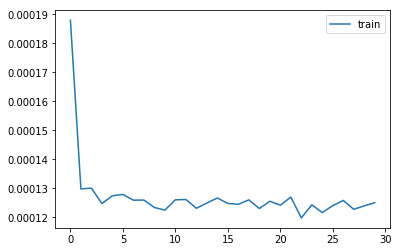

In [18]:
# plot history
plt.plot(fitpr25.history['loss'], label='train')
plt.legend()
plt.show()

## Reshape test data input to be 3D [samples, timesteps, features]

In [19]:

X_test= X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_test.shape, y_test.shape)

(115217, 1, 35) (115217, 1)


### Prediction

In [20]:

ypred   = model.predict(X_test)

In [21]:
# invert scaling for forecast
inv_ypred =scale_fit2.inverse_transform(ypred)
inv_ypred = inv_ypred[:,0]


In [22]:
# invert scaling for actual
inv_y =scale_fit2.inverse_transform(y_test)
inv_y = inv_y[:,0]


In [23]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_ypred))
print('Test RMSE: %.6f' % rmse)

Test RMSE: 448.772205
